In [28]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd

import detailedbalance as db

font = {'size' : 22}

matplotlib.rc('font',**font)
%matplotlib inline

In [29]:
# Just some constants for the upcoming math
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant in eV s')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant in eV/K')

pi = 3.1415

# Globals
Tcell = 300  # Kelvin
# Energy Gap
Egap = 1.1  #electron volts

r_earth = 6e6
r_sun = 6.95e8
d_sun = 1.50e11

In [30]:
E_ph = np.arange(0.01, 10,0.001) 
E_ph = np.flip(E_ph,0)

E_gaps = np.arange(0.3, 5,0.01) 
E_gaps = np.flip(E_gaps,0)

sourcetype = 1 

constants = {}

# sourcetype 1 for sun and 0 for full angle. This should perhaps be combined with the max_eff_temp function
if(sourcetype):
    #Sun
    constants['Temp'] = 5750
    constants['solidangle'] = db.solid_angle_sun(r_earth,d_sun)
    constants['emitterarea'] = 4*pi*r_sun**2
    constants['absorberarea'] = pi*r_earth**2
else:
    #Custom
    constants['Temp'] = 5500
    constants['solidangle'] = 2*pi
    constants['emitterarea'] = 1
    constants['absorberarea'] = 1
    
constants['emissivity'] = db.gen_emissivity(1,1,1.1,E_ph)
#constants['emissivity'] = db.lor_emissivity(0,1,3,0.00001,E_ph)
   
BB = db.gen_spectrum(E_ph,constants)

#BB = db.gen_spectrum_lor(E_ph,0,1,1.12,0.00001)


#check integrated irradiance is ~1kW/m^2
integrate = -np.trapz(BB[:,1],BB[:,0] )
print(integrate)

#BB[:,1] = BB[:,1]/integrate
BB[:,1] = BB[:,1]
#BB[:,1] = 0

print(BB[:,1].min())
integrate = -np.trapz(BB[:,1],BB[:,0] )
print(integrate)


BB_ph = db.power_to_photons(BB)

print(db.stephan(5750)*4*pi*r_sun**2)

1330.624524633602
0.0058519120292353346
1330.624524633602
3.762263521545546e+26


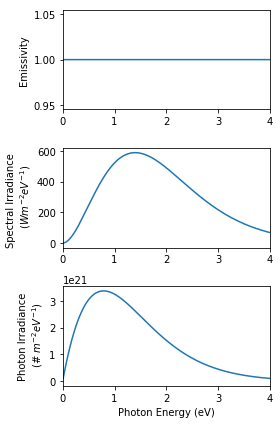

In [31]:
w,h =plt.figaspect(1.5) 
fig, ax = plt.subplots(3,1,figsize = (w,h) )
ax[0].plot(E_ph,constants['emissivity'])
ax[0].set_xlim(0,4)
ax[0].set_ylabel('Emissivity')

ax[1].plot(BB[:,0],BB[:,1] )
ax[1].set_xlim(0,4)
ax[1].set_ylabel('Spectral Irradiance \n ($Wm^{-2}eV^{-1}$)')

ax[2].plot(BB_ph[:,0],BB_ph[:,1] )
ax[2].set_xlim(0,4)
ax[2].set_ylabel('Photon Irradiance\n (# $m^{-2}eV^{-1}$)')
plt.xlabel('Photon Energy (eV)')

plt.tight_layout()

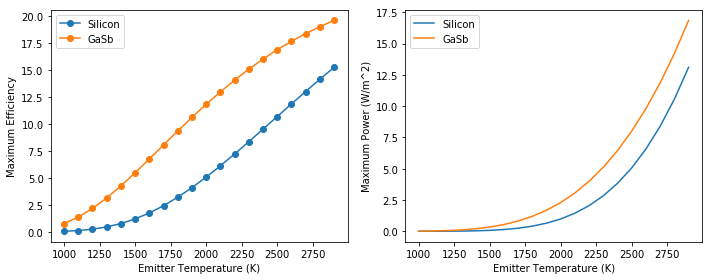

In [32]:
temps = pd.Series(np.arange(1000,3000,100))

spectra_ph_temp = pd.Series(index = temps,dtype=object)
for temp in temps:
    constants['Temp'] = temp
    spectra = db.gen_spectrum(E_ph,constants)
    spectra_ph_temp[temp] = db.power_to_photons(spectra)
    
max_eff_all_Si_temp, max_eff_all_GaSb_temp, max_pow_all_Si_temp,max_pow_all_GaSb_temp = db.max_eff_array(spectra_ph_temp,temps)


w,h =plt.figaspect(0.4) 
fig, ax = plt.subplots(1,2,figsize = (w,h) )

ln1 = ax[0].plot(max_eff_all_Si_temp, '-o')
ln2 = ax[0].plot(max_eff_all_GaSb_temp,'-o')
ax[0].set_ylabel('Maximum Efficiency')
ax[0].set_xlabel('Emitter Temperature (K)')
lns = ln1 + ln2
ax[0].legend(lns, ('Silicon','GaSb'))

ln1 = ax[1].plot(max_pow_all_Si_temp)
ln2 = ax[1].plot(max_pow_all_GaSb_temp)
lns = ln1 + ln2
ax[1].legend(lns, ('Silicon','GaSb'))
ax[1].set_ylabel('Maximum Power (W/m^2)')
ax[1].set_xlabel('Emitter Temperature (K)')

plt.tight_layout()

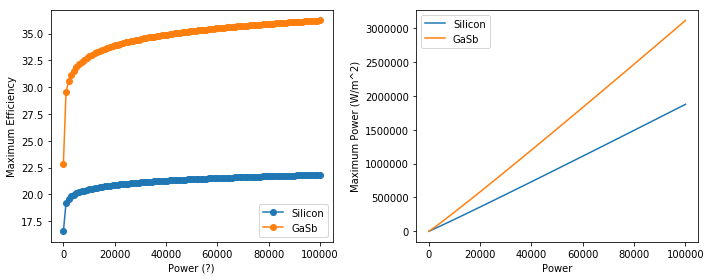

In [33]:
powers = pd.Series(np.linspace(10, 10**5,100))
spectra_ph_pow = pd.Series(index = powers,dtype=object)
for power in powers:
    spectra = db.gen_spectrum(E_ph,constants)
    spectra[:,1] = spectra[:,1]*power
    spectra_ph_pow[power] = db.power_to_photons(spectra)
    
max_eff_all_Si_pow, max_eff_all_GaSb_pow, max_pow_all_Si_pow,max_pow_all_GaSb_pow = db.max_eff_array(spectra_ph_pow,powers)

w,h =plt.figaspect(0.4) 
fig, ax = plt.subplots(1,2,figsize = (w,h) )

ln1 = ax[0].plot(max_eff_all_Si_pow, '-o')
ln2 = ax[0].plot(max_eff_all_GaSb_pow,'-o')
ax[0].set_ylabel('Maximum Efficiency')
ax[0].set_xlabel('Power (?)')
lns = ln1 + ln2
ax[0].legend(lns, ('Silicon','GaSb'))

ln1 = ax[1].plot(max_pow_all_Si_pow)
ln2 = ax[1].plot(max_pow_all_GaSb_pow)
lns = ln1 + ln2
ax[1].legend(lns, ('Silicon','GaSb'))
ax[1].set_ylabel('Maximum Power (W/m^2)')
ax[1].set_xlabel('Power')

plt.tight_layout()

In [34]:
print('For a cell with bandgap %.2f eV' % Egap)
print('max power %.2f' % db.max_power(Egap, BB_ph) )
print('Irradiance %.2f' % db.int_irr(Egap, BB_ph ))
print('Ideal efficiency is {:.4}%'.format(db.max_eff(Egap, BB_ph)*100))

For a cell with bandgap 1.10 eV
max power 397.30
Irradiance 1330.62
Ideal efficiency is 29.86%


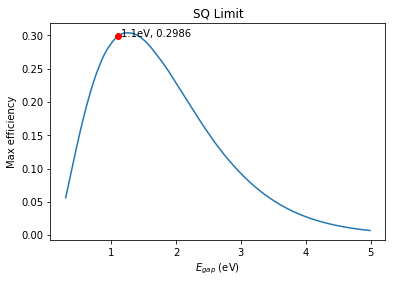

In [35]:
db.sq_limit_plot(BB_ph,E_gaps)

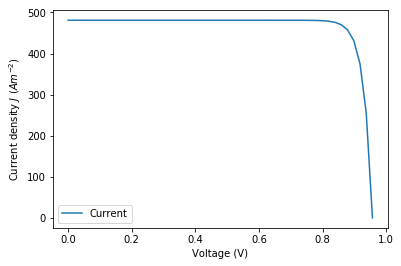

In [36]:
db.iv_curve_plot(1.2, BB_ph)

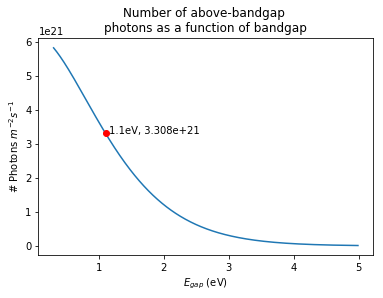

In [37]:
db.photons_above_bandgap_plot(BB_ph,E_gaps)

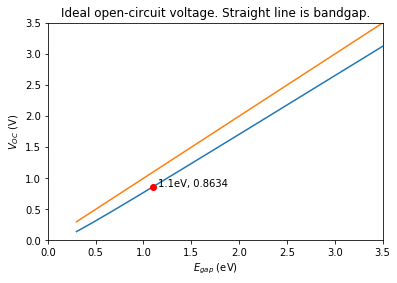

In [38]:
db.ideal_voc_plot(BB_ph,E_gaps)

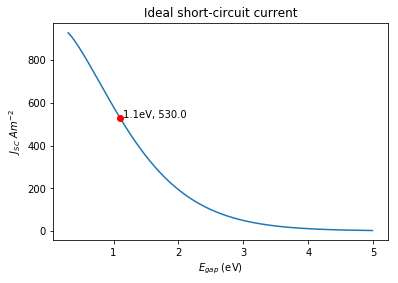

In [39]:
db.ideal_jsc_plot(BB_ph,E_gaps)

In [40]:
# For an ideal solar cell these will be
print('A material with a bandgap of %.2f will have an:' % Egap)
print('Ideal short circuit current: ', db.jsc(Egap, BB_ph), 'A/m^2')
print('Ideal open circuit  voltage: ', db.voc(Egap, BB_ph), 'V')


#watch out for minus 1

A material with a bandgap of 1.10 will have an:
Ideal short circuit current:  530.0133623518966 A/m^2
Ideal open circuit  voltage:  0.8633806569946915 V
